# Authentication Service 

## Use this to make connections and challenge them to present specific attributes

## Challenge yourself to present the workshop attendance credential if you received one on your mobile

Customise these notebooks or the code within the libs folder as you like. It should be fairly easy to combine this code with the messaging service. 

Also check out the recipes folder for some basic templates for typical agent flows using the aries-cloudcontroller

### Imports

In [1]:
from aries_cloudcontroller import AriesAgentController
from libs.authentication_service import AuthenticationService
import os
import time
from termcolor import colored

### Initialise the Agent Controller

In [2]:
api_key = os.getenv("ACAPY_ADMIN_API_KEY")
admin_url = os.getenv("ADMIN_URL")

print(f"Initialising a controller with admin api at {admin_url} and an api key of {api_key}")
agent_controller = AriesAgentController(admin_url,api_key)

Initialising a controller with admin api at http://hlgf-agent:3021 and an api key of adminApiKey


### Start a Webhook Server

In [3]:
webhook_port = int(os.getenv("WEBHOOK_PORT"))
webhook_host = "0.0.0.0"

await agent_controller.init_webhook_server(webhook_host, webhook_port)

print(f"Listening for webhooks from agent at http://{webhook_host}:{webhook_port}")

Listening for webhooks from agent at http://0.0.0.0:3010


## Iniitalise the AuthenticationService


In [4]:
authentication_service = AuthenticationService(agent_controller)

## Define Your Presentation Request Object

The one below is for the Aries ACA ACC Jupyter Playground Demo Participation credential. It also requests a self attested attribute for your nickname

In [5]:
# We add a constraint that the attribute must originate from this schema
schema_id = "W4t2Pa4XR1qBDvwhVcn4CY:2:Aries ACA ACC Jupyter Playground Demo Participation:0.0.1"


# Define the list of attributes and restrictions under which each attribute was issued that a prover must satisfy with a presentation
# NOTE: if identifying a schema or credential definition then the attribute name must be contained within the corresponding schema.
req_attrs = [
    {"name": "Participant", "restrictions": [{"schema_id": schema_id}]},
    # A self attested attribute. No restrictions so the prover can attest to any value for this
    {"name": "nickname", "restrictions": []}
]

# We could extend this to request the name attribute aswell if we wanted.


playground_proof = {
    "name": "Proof of Playground",
    "version": "1.0",
    "requested_attributes": {
        # They generally follow this uuid pattern. Unique identifier for attribute within context of this proof request
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
    },
    # Predicates allow us to specify range proofs or set membership on attributes. For example greater than 10.
    # We will ignore these for now.
    "requested_predicates": {
#         f"0_{req_pred['name']}_GE_uuid":
#         req_pred for req_pred in req_preds
    },
    # You can also request the entire proof request be non-revoked
    "non_revoked":  {"to": int(time.time())}
}

## Create Invitation using AuthenticationService for Mobile


In [6]:
response = authentication_service.new_connection_invitation(playground_proof, for_mobile=True)
connection_id = response["connection_id"]
invitation_url = response["invitation_url"]

----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  1c17a596-2f28-41f7-99b5-8532f6dbf9d4
State :  invitation
Routing State :  none
Their Role :  invitee
----------------------------------------------------------


## Display Invite as QR Code

This is useful if you wish to establish a connection with a mobile wallet.

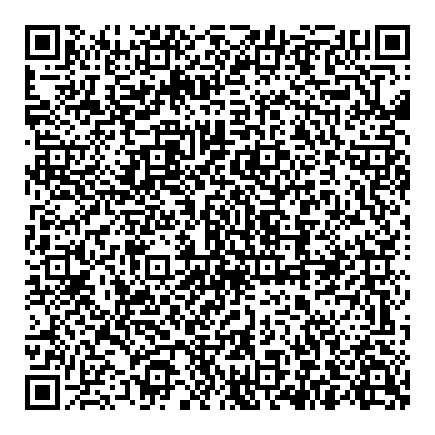

In [7]:
import qrcode
# Link for connection invitation
invitation_url = response["invitation_url"]
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=5,
        border=5)
qr.add_data(invitation_url)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img

## Create Inivtation JSON using AuthenticationService

E.g. if you want to connect with another agent running through this notebook interface

In [8]:
response = authentication_service.new_connection_invitation(playground_proof)
connection_id = response["connection_id"]
invitation = response["invitation"]

----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  e453dd1b-2f77-4a03-9935-088842e91732
State :  invitation
Routing State :  none
Their Role :  invitee
----------------------------------------------------------
----------------------------------------------------------------------------------------------------

Share this invite object with another entity

{'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/connections/1.0/invitation', '@id': 'a0dd1e7f-1c76-43b0-8303-85f2ca1c137a', 'recipientKeys': ['EqLEBoSnqrKS68N9RnWNvXr9NfkGvrj79q8ZPtKWMpGg'], 'serviceEndpoint': 'http://a7e8d54c0b8f.ngrok.io', 'label': 'Hyperledger Global Forum'}


----------------------------------------------------------------------------------------------------


## Get Connections for Authentication Service



In [9]:
connections = authentication_service.get_connections()
for connection in connections:
    print("Connection ID : ", connection.connection_id)
    print("Is Active : ", connection.is_active.done() and connection.is_active.result() == True)
    print("Is Trusted : ", connection.is_active.done() and connection.is_trusted.done() and connection.is_trusted.result() == True)
    print("Auth Policy Name : " , connection.auth_policy["name"])
    print("Verified Attributes : ", connection.verified_attributes)
    print("Self Attested Attributes : ", connection.self_attested_attributes)

Connection ID :  1c17a596-2f28-41f7-99b5-8532f6dbf9d4
Is Active :  False
Is Trusted :  False
Auth Policy Name :  Proof of Playground
Verified Attributes :  []
Self Attested Attributes :  []
Connection ID :  e453dd1b-2f77-4a03-9935-088842e91732
Is Active :  False
Is Trusted :  False
Auth Policy Name :  Proof of Playground
Verified Attributes :  []
Self Attested Attributes :  []


## Terminate Controller

Whenever you have finished with this notebook, be sure to terminate the controller. This is especially important if your business logic runs across multiple notebooks.

In [ ]:
await agent_controller.terminate()